# Summary

```Objective```

Check what is MIND descriptor that is mentioned in SC-CycleGAN paper

```Methods```

use the function in misalign.models.components.mind_descriptor.MIND_descriptor2D

```Results```

todo

# Config

# Libs

In [2]:
import torch
from misalign.data.IXI_datamodule import IXIDataModule
from misalign.models.components.scgan_loss import *
from monai.visualize import matshow3d
from misalign.draw import blend_and_transpose
import matplotlib.pyplot as plt 


# Analysis

No misalignment

path exists for /home/kanghyun/misalign-benchmark/data/IXI/train/prepared_data_0_0.h5
path exists for /home/kanghyun/misalign-benchmark/data/IXI/val/prepared_data_0.0_0.0.h5
path exists for /home/kanghyun/misalign-benchmark/data/IXI/test/prepared_data_0.0_0.0.h5
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


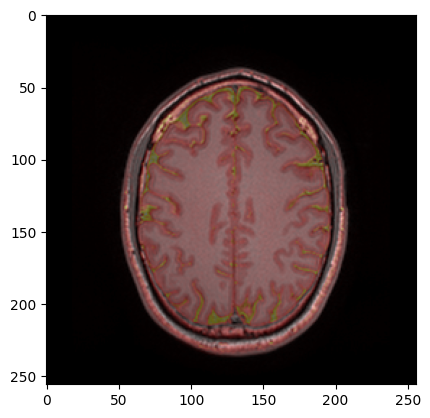

In [3]:
misalign_x = 0
misalign_y = 0

_ = IXIDataModule('/home/kanghyun/misalign-benchmark/data/IXI', batch_size=1, misalign_x=misalign_x, misalign_y=misalign_y)
_.prepare_data()
_.setup()
train_data = _.train_dataloader()

for a, b in train_data:
    print(a.shape, b.shape)
    break

for _a, _b in zip(a,b):
    blended_img = blend_and_transpose(_a[0], _b[0])
    plt.imshow(blended_img)
    plt.show()
    break

_a = torch.Tensor(_a)
_b = torch.Tensor(_b)


In [4]:

feat_a = mind(_a[None].cuda(), sigma=2)
feat_b = mind(_b[None].cuda(), sigma=2)

print(feat_a.shape, feat_b.shape)


/home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 1, 242, 242, 99]) torch.Size([1, 1, 242, 242, 99])


Text(0.5, 1.0, 'MIND feature for image _b')

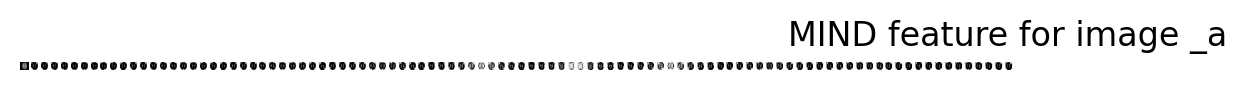

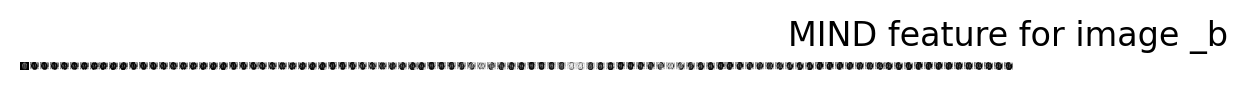

In [5]:
plt.figure(dpi=200)
plt.subplot(1,feat_a.shape[-1]+1,1)
plt.imshow(_a.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
for _d in range(feat_a.shape[-1]):
    plt.subplot(1,feat_a.shape[-1]+1,_d+2)
    plt.imshow(feat_a[0,0,...,_d].detach().cpu(), cmap='gray')
    plt.axis('off')
plt.title('MIND feature for image _a')

plt.figure(dpi=200)
plt.subplot(1,feat_a.shape[-1]+1,1)
plt.imshow(_b.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')

for _d in range(feat_b.shape[-1]):
    plt.subplot(1,feat_b.shape[-1]+1,_d+2)
    plt.imshow(feat_b[0,0,...,_d].detach().cpu(), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
plt.title('MIND feature for image _b')


In [6]:

mind_tf = MIND()

In [9]:
test = _a[None]

In [69]:
def get_gausian_filter(sigma, sz):
    xpos, ypos = torch.meshgrid(torch.arange(sz), torch.arange(sz))
    output = torch.ones([sz, sz, 1, 1])
    midpos = sz // 2
    d = (xpos-midpos)**2 + (ypos-midpos)**2
    gauss = torch.exp(-d / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    return gauss


def gaussian_filter(img, n, sigma):
    """
    img: image tensor of size (1, 1, height, width)
    n: size of the Gaussian filter (n, n)
    sigma: standard deviation of the Gaussian distribution
    """
    # Create a Gaussian filter
    gaussian_filter = get_gausian_filter(sigma, n)
    
    # Add extra dimensions for the color channels and batch size
    gaussian_filter = gaussian_filter.view(1, 1, n, n)
    
    gaussian_filter = gaussian_filter.to(img.device)
    
    # Perform 2D convolution
    filtered_img = F.conv2d(img, gaussian_filter, padding=n//2)
    
    return filtered_img

def Dp(image, sigma, patch_size, xshift, yshift):
    shift_image = torch.roll(image, shifts=(xshift, yshift), dims=(-1, -2))
    diff = image - shift_image
    diff_square = diff ** 2
    res = gaussian_filter(diff_square, patch_size, sigma)
    return res

class MIND(nn.Module):
    def __init__(self, option={'sigma':2.0, 'eps':1e-5, 'neigh_size':9, 'patch_size':7}):
        super(MIND, self).__init__()
        self.option = option
        self.reduce_size = (option['patch_size'] + option['neigh_size'] - 2) // 2

    def forward(self, image):
        # estimate the local variance of each pixel within the input image.
        Vimg = Dp(image, self.option['sigma'], self.option['patch_size'], -1, 0) + Dp(image, self.option['sigma'], self.option['patch_size'], 1, 0) + \
               Dp(image, self.option['sigma'], self.option['patch_size'], 0, -1) + Dp(image, self.option['sigma'], self.option['patch_size'], 0, 1)
        Vimg = Vimg / 4 + self.option['eps'] * torch.ones_like(Vimg)

        # estimate the (R*R)-length MIND feature by shifting the input image by R*R times.
        xshift_vec = np.arange( -(self.option['neigh_size']//2), self.option['neigh_size'] - (self.option['neigh_size']//2))
        yshift_vec = np.arange(-(self.option['neigh_size'] // 2), self.option['neigh_size'] - (self.option['neigh_size'] // 2))
        
        #print(xshift_vec, yshift_vec)
        
        iter_pos = 0
        for xshift in xshift_vec:
            for yshift in yshift_vec:
                if (xshift,yshift) == (0,0):
                    continue
                MIND_tmp = torch.exp(-Dp(image, self.option['sigma'], self.option['patch_size'], xshift, yshift) / Vimg) # MIND_tmp : 1x1x256x256
                tmp = MIND_tmp[...,self.reduce_size:-self.reduce_size, self.reduce_size:-self.reduce_size,None] # 1x1x250x250x1
                output = tmp if iter_pos == 0 else torch.cat((output,tmp), -1)
                iter_pos += 1

        # normalization.
        output = torch.divide(output, torch.max(output, dim=-1, keepdim=True)[0])

        return output


In [74]:
mind = MIND(option={'sigma':2.0, 'eps':1e-5, 'neigh_size':5, 'patch_size':7})

In [77]:

feat_a = mind(_a[None].cuda())
feat_b = mind(_b[None].cuda())
print(feat_a.shape)

torch.Size([1, 1, 246, 246, 24])


Text(0.5, 1.0, 'MIND feature for image _b')

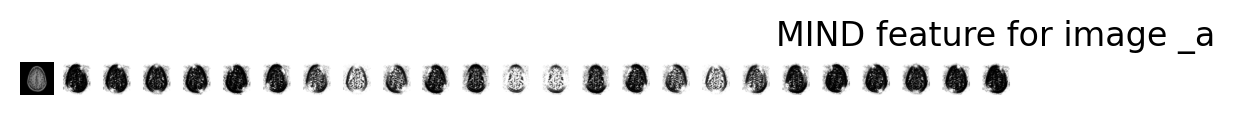

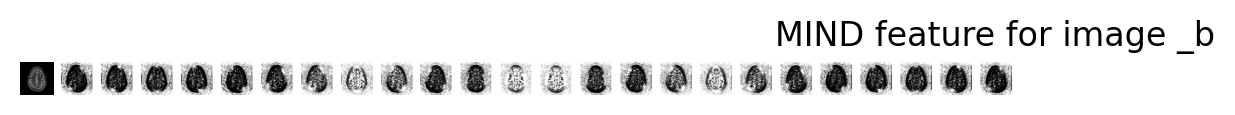

In [76]:
plt.figure(dpi=200)
plt.subplot(1,feat_a.shape[-1]+1,1)
plt.imshow(_a.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
for _d in range(feat_a.shape[-1]):
    plt.subplot(1,feat_a.shape[-1]+1,_d+2)
    plt.imshow(feat_a[0,0,...,_d].detach().cpu(), cmap='gray')
    plt.axis('off')
plt.title('MIND feature for image _a')

plt.figure(dpi=200)
plt.subplot(1,feat_a.shape[-1]+1,1)
plt.imshow(_b.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')

for _d in range(feat_b.shape[-1]):
    plt.subplot(1,feat_b.shape[-1]+1,_d+2)
    plt.imshow(feat_b[0,0,...,_d].detach().cpu(), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
plt.title('MIND feature for image _b')


In [34]:
test.shape

torch.Size([80, 1, 242, 242])

In [40]:
test.dtype

torch.float32

In [44]:
test2 = test / test.max(dim=0,keepdim=True)

TypeError: unsupported operand type(s) for /: 'MetaTensor' and 'torch.return_types.max'